## References

* Brenowitz, N, 2017: [lorenz63_slp](https://atmos.washington.edu/~nbren12/reports/2017/lorenz63_slp.html)
* Müller-Komorowska, D, 2021: [Differential Equations with SciPy – odeint or solve_ivp](https://danielmuellerkomorowska.com/2021/02/16/differential-equations-with-scipy-odeint-or-solve_ivp/)
* [scipy.integrate](https://docs.scipy.org/doc/scipy/reference/reference/integrate.html)
* [Scikit-Learn API](https://scikit-learn.org/stable/modules/classes.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def florenz(w, p, r, b):
    x, y, z = w
    dw = np.zeros_like(w)
    dw[0] =      -p * x + p * y 
    dw[1] = (r - z) * x -     y 
    dw[2] =           x * y     - b * z
    return dw

In [3]:
def fom(nexp, ncyc, w, param):
    p, r, b, dt, nstop = param
    x = np.zeros([nstop+1, w.size])
    x[0, :] = w
    fname = f"m{nexp:02}c{ncyc:03}.npy"
    for ntim in range(1, nstop+1):
        w += dt * florenz(w, p, r, b)
        x[ntim, :] = w
    np.save(fname, x)
    return w

In [4]:
nexp = 81
p, r, b, dt, nstop = 10.0, 32.0, 8/3, 0.01, 10000
w0 = np.array([1.0, 3.0, 5.0])
param = p, r, b, dt, nstop
_ = fom(nexp, 0, w0, param)
w = np.load(f"m{nexp:02}c000.npy")

In [5]:
w.shape

(10001, 3)

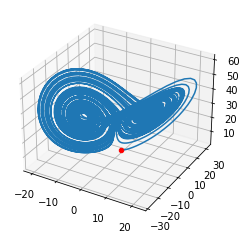

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*w[0,:], c="red")
ax.plot(*w.transpose())

# Artificial neural network

## Construction

In [7]:
dwdt = (w[1:] - w[:-1]) / dt

In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

nn = make_pipeline(StandardScaler(), MLPRegressor())

## Learning

In [9]:
nn.fit(w[1:], dwdt)

c:\users\subhi\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor', MLPRegressor())])

## Quick check

In [10]:
w0  + dt * nn.predict(w0[None,])

array([[-5.74186207,  2.58382571, 35.95554077]])

In [11]:
w[1,]

array([1.2       , 3.24      , 4.89666667])

## True vs estimated tendencies

In [12]:
dwdt_nn = nn.predict(w[0:-1])

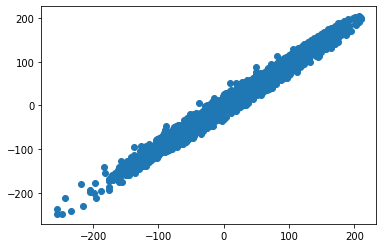

In [13]:
fig, ax = plt.subplots()
ax.scatter(dwdt[:, 0], dwdt_nn[:, 0])

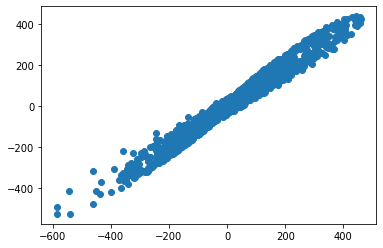

In [14]:
fig, ax = plt.subplots()
ax.scatter(dwdt[:, 1], dwdt_nn[:, 1])

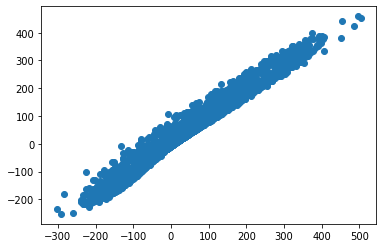

In [15]:
fig, ax = plt.subplots()
ax.scatter(dwdt[:, 2], dwdt_nn[:, 2])

# Forecast with the neural network model

## Old interface: `odeint`

In [16]:
from scipy.integrate import odeint

def florenz_nn(x, args):
    return nn.predict(x[None,]).ravel()

w_nn = odeint(florenz_nn, w0, np.linspace(0, 100, 10001))

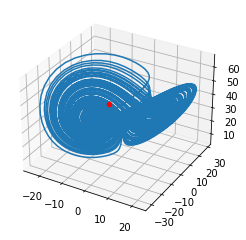

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*w0, c="red")
ax.plot(*w_nn.transpose())

## New interface: `solve_ivp`

In [18]:
from scipy.integrate import solve_ivp

def florenz_nn(t, x):
    return nn.predict(x[None,]).ravel()

t_span = (0, 100)
result_ivp = solve_ivp(florenz_nn, t_span, w0)

In [19]:
result_ivp.y.shape

(3, 1284)

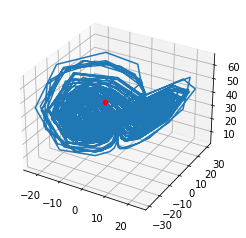

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*w0, c="red")
ax.plot(*result_ivp.y)

## The Euler method

unstable.

In [21]:
def florenz_nn(x):
    return nn.predict(x[None,]).ravel()

w_nn_eul = np.zeros([nstop+1, w0.size])
w_nn_eul[0] = w0
for n in range(nstop):
    w_nn_eul[n+1] = w_nn_eul[n] + dt * florenz_nn(w_nn_eul[n])

c:\users\subhi\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


ValueError: Input contains infinity or a value too large for dtype('float64').